# Capstone Project - Fraud Detection

Using Classification to Predict Fraudulent Claims

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [15]:
df = pd.read_csv("insurance_claims.csv")

# Drop null column
df.drop(columns=['_c39'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

df.replace('?', pd.NA, inplace=True)
for col in ['collision_type', 'property_damage', 'police_report_available']:
    df[col].fillna('Unknown', inplace=True)

# Convert fraud_reported to binary
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})



/tmp/ipython-input-15-2320655687.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


## Exploratory Data Analysis

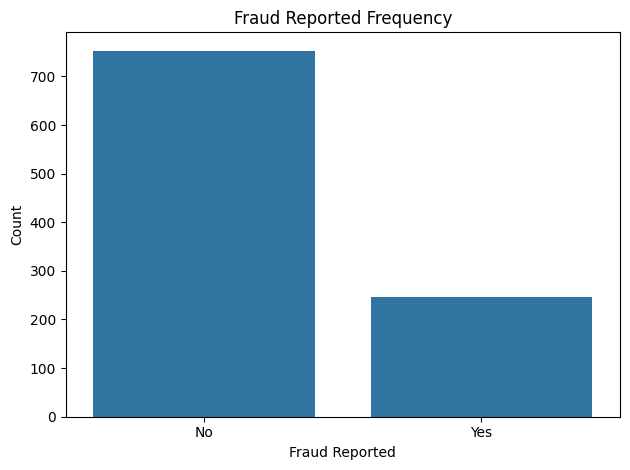

In [16]:
sns.countplot(x='fraud_reported', data=df)
plt.title('Fraud Reported Frequency')
plt.xlabel('Fraud Reported')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


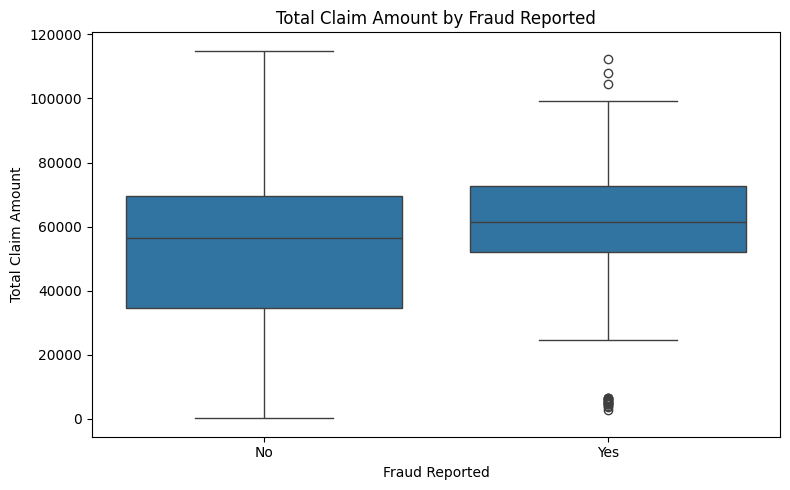

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='fraud_reported', y='total_claim_amount', data=df)
plt.title('Total Claim Amount by Fraud Reported')
plt.xlabel('Fraud Reported')
plt.ylabel('Total Claim Amount')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


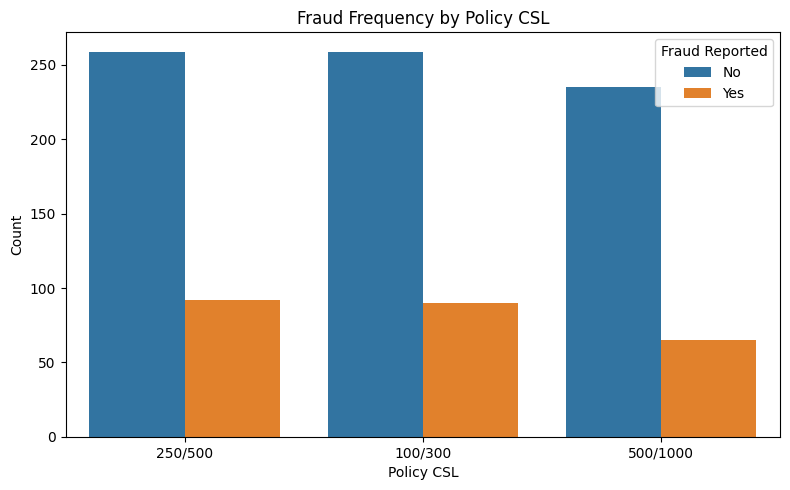

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='policy_csl', hue='fraud_reported', data=df)
plt.title('Fraud Frequency by Policy CSL')
plt.xlabel('Policy CSL')
plt.ylabel('Count')
plt.legend(title='Fraud Reported', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


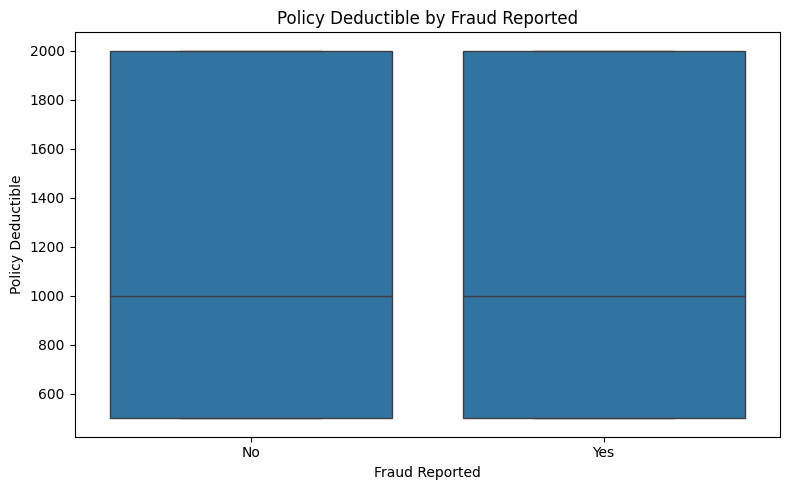

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='fraud_reported', y='policy_deductable', data=df)
plt.title('Policy Deductible by Fraud Reported')
plt.xlabel('Fraud Reported')
plt.ylabel('Policy Deductible')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


## Feature Engineering and Encoding

In [20]:
# One-hot encoding for categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Drop non-predictive columns
cols_to_drop = ['policy_number', 'insured_zip', 'incident_location',
                'incident_date', 'policy_bind_date']
df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns], inplace=True)


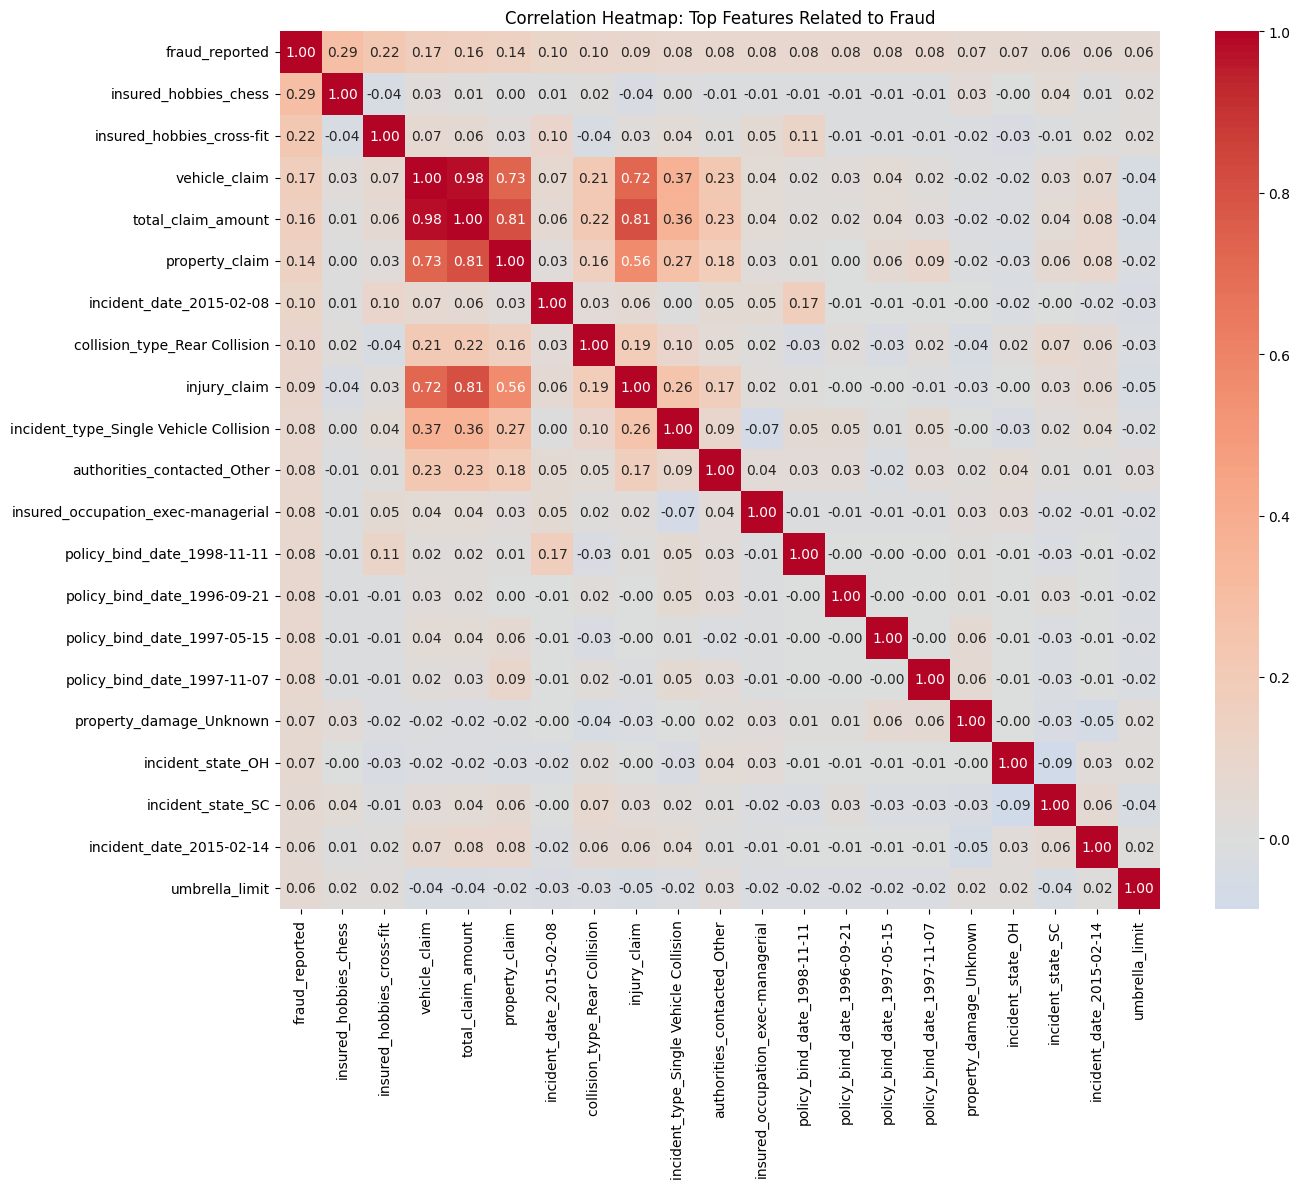

In [21]:
# Compute correlation matrix
corr_matrix = df_encoded.corr()

corr_target = corr_matrix[['fraud_reported']].sort_values(by='fraud_reported', ascending=False)

top_corr_features = corr_target.index[:21]

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(df_encoded[top_corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0, annot_kws={"size": 10})
plt.title("Correlation Heatmap: Top Features Related to Fraud")
plt.tight_layout()
plt.show()

## Classification Model: Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.72      0.61      0.66       145
           1       0.27      0.38      0.32        55

    accuracy                           0.55       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.60      0.55      0.57       200



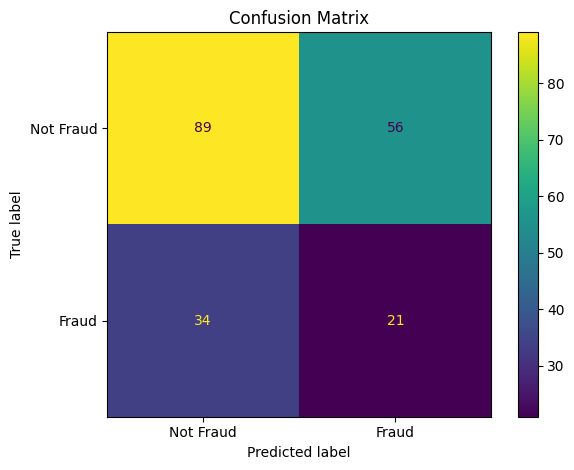

In [22]:
# Define features and target
X = df_encoded.drop(columns=['fraud_reported'])
y = df_encoded['fraud_reported']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight = 'balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot()
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Logistic Regression was selected as the **baseline model** for this fraud detection task due to the following reasons:

- **Simplicity & Interpretability**:  
  Logistic Regression provides clear, interpretable coefficients, helping stakeholders understand which features most influence the likelihood of fraud.

- **Ideal for Binary Classification**:  
  The target variable (`fraud_reported`) is binary (Yes/No), which Logistic Regression is specifically designed to handle.

- **Baseline Benchmarking**:  
  It establishes a reliable, lightweight benchmark to compare against more advanced models like Random Forests or XGBoost.

- **Handles Class Imbalance with `class_weight='balanced'`**:  
  This is critical for fraud detection, where fraudulent claims make up a small portion of the dataset.

---

### Why These Evaluation Metrics?

Because the dataset is **highly imbalanced** (very few fraud cases), traditional accuracy can be misleading — a model that always predicts "Not Fraud" could still appear accurate. Therefore, we used the following metrics:

| Metric         | Purpose                                                                 |
|----------------|-------------------------------------------------------------------------|
| **Precision**  | Of all predicted fraud cases, how many were actually fraud? <br>Useful for reducing false accusations. |
| **Recall**     | Of all actual fraud cases, how many did we correctly identify? <br>Critical for ensuring fraud is not missed. |
| **F1 Score**   | Harmonic mean of precision and recall. <br>Balanced view of model performance under class imbalance. |
| **Confusion Matrix** | Visual breakdown of true vs. false positives and negatives, providing a holistic view of prediction quality. |

> Although accuracy was calculated, the **primary focus was recall and F1 score**, since these better reflect a model’s ability to detect rare but important fraudulent cases.

---
